<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://erachelson.github.io/RLclass_MVA/">https://erachelson.github.io/RLclass_MVA/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Chapter 3: Learning value functions</div>

<div class="alert alert-success">

**Learning outcomes**  
By the end of this chapter, you should be able to:
- explain approximate value iteration and recall its (non-)convergence properties,
- explain why and how approximate dynamic programming can be cast as a series of risk minimization problems,
- write a TD(0) algorithm for value function estimation and explain its properties,
- write a Q-learning algorithm for value function estimation and explain its properties,
- identify and explain the three intrinsic challenges of RL which are value function approximation, the improvement problem and the exploration vs. exploitation tradeoff.

Additionally, after doing the homework, you should be able to:
- explain the difference between on-policy and off-policy algorithms,
- implement $n$-step temporal difference estimators, from Monte Carlo ones to TD($\lambda$),
- discuss the impact of the behavior distribution on risk minization,
- implement SARSA.
</div>

# Approximate dynamic programming

Let's take a step back on the contents of the previous chapter.

With the Bellman equation, we have a way to **characterize** $Q^*$. This characterization directly translates to the **Value Iteration** algorithm. In turn, once we know $Q^*$, we can deduce $\pi^*$.

That's all very nice, but is it applicable in practice, on real world examples? In particular, how does the computation of $Q^*$ scale with large state and action spaces?

<div class="alert alert-warning">
    
**Exercise**  
Do you recall the time complexity of a single iteration of value iteration in terms of $|S|$ and $|A|$?  
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

$O(S^2 A)$
</details>

The curse of dimensionality makes the number of states and actions scale exponentially with the dimension of the state and action spaces. So exact computation of $Q^*$ quickly becomes intractable, as building $Q_{n+1} = T^*Q_n$ from $Q_n$ requires $|S|$ operations in every state-action pair (hence the complexity in the exercise above).

Instead, one can try to *approximate* the resolution of $T^* Q_n$ at each step of Value Iteration. This yields the Approximate Value Iteration algorithm.

<div class="alert alert-success">
    
**Approximate Value Iteration** is the algorithm that computes the sequence $Q_{n+1} = \mathcal{A} T^* Q_n$, where $\mathcal{A}$ is an approximation procedure.
</div>

Note in particular that when dealing with parametric functions $Q_\theta$, finding a minimizer of the loss
$L_n(\theta) = \| Q_\theta - T^* Q_n \|$
is such an approximation procedure.

Let us suppose that $\mathcal{A}$ is not a bad approximation procedure and that its approximation error is uniformly bounded, that is, 
$$\forall f \in \mathbb{R}^{SA}, \ \| f-\mathcal{A}f \|_\infty \leq \epsilon.$$

The first important result is that Approximate Value Iteration **does not converge**. However, one can prove that $Q_n$ reaches a neighborhood of $Q^*$. Specifically, there exists $N$ such that for all $n\geq N$,
$$\| Q^* - Q_n \|_\infty \leq \frac{\epsilon}{1-\gamma}.$$

More importantly, let $\pi_n$ be the greedy policy with respect to $Q_n$, then:
$$\|Q^*-Q^{\pi_n}\|_\infty \leq \frac{2\gamma}{1-\gamma} \|Q^*-Q_n\|_\infty.$$

And consequently, for such $n\geq N$,
$$\|Q^*-Q^{\pi_n}\|_\infty \leq \frac{2\gamma\epsilon}{(1-\gamma)^2}.$$

So,
<div class="alert alert-success">

Approximate Value Iteration does not necessarily converge but reaches policies whose values are close to optimal.
</div>

These results are proven in the **[Neuro-dynamic programming](http://athenasc.com/ndpbook.html)** book by D. P. Bertsekas and J. Tsitsiklis (1996).

Most supervised learning algorithms minimize a loss that is expressed as a weighted $L_2$ norm. Thus, they don't explicitly provide guarantees in $L_\infty$ norm. R. Munos provided **[error bounds for approximate value iteration](https://www.aaai.org/Papers/AAAI/2005/AAAI05-159.pdf)** in the general case of weighted $L_p$ norms. Those bounds are similar to the one in $L_\infty$ norm, thus justifying the use of supervised learning techniques (such as neural networks or random forests for instance) in Approximate Value Iteration.

**Approximate value iteration generalizes value iteration**

Let us stress this out: approximate value iteration fully generalizes value iteration.  
The Bellman optimality equation defines $Q^*$ as the solution to $Q=T^* Q$. This solution belongs to the space $\mathbb{R}^{SA}$ of functions from $S\times A$ to $\mathbb{R}$. This space of functions is a vector space whose dimension is the cardinality of $S\times A$. Hence, beyond the case of finite state and action spaces, no finite basis of functions can span $\mathbb{R}^{SA}$ and searching for a solution to $Q=T^* Q$ is searching inside an infinite dimensional space.  

When $\mathcal{A}$ turns out to be exact (that is, its approximation error $\epsilon$ is null), then AVI boils down to VI.  
This can happen when $S$ and $A$ are discrete and the functions $\mathbb{R}^{SA}$ are represented exactly as vectors in $\mathbb{R}^{|S||A|}$. But this can happen also in continuous state or action spaces with very specific hypotheses, where the optimality equation admits a closed-form solution. An example of this where the value function is a polynomial function of a continuous state variable is developped in these [two](https://papers.nips.cc/paper_files/paper/2000/hash/09b15d48a1514d8209b192a8b8f34e48-Abstract.html) [papers](https://ieeexplore.ieee.org/abstract/document/5364653).

On the other hand, when the state-action space is continuous, or just too large to be enumerated, AVI trades exact construction of the $Q_{n+1} = T^*Q_n$ sequence for scalability, by constructing an approximate sequence $Q_{n+1} = \mathcal{A} T^* Q_n$ that still provides good policies if $\mathcal{A}$ is a good approximation procedure.

**And approximate (modified) policy iteration?**

Approximate Policy Iteration consists in solving the evaluation equation up to a certain precision $\epsilon$ and then taking a greedy improvement step.

We write $V_n$ the approximation of $V^{\pi_n}$ at the end of an evaluation phase in Policy Iteration and suppose that the approximation error is uniformly bounded:
$$\| V^{\pi_n} - V_n \|_\infty \leq \epsilon.$$

Then it is known that, even though the sequence of greedy policies $\pi_n$ does not converge, it oscillates among a set of policies such that:
$$\|V^*-V^{\pi_n}\|_\infty \leq \frac{2\gamma\epsilon}{(1-\gamma)^2}.$$

This result is also proven in the **[Neuro-dynamic programming](http://athenasc.com/ndpbook.html)** book by D. P. Bertsekas and J. Tsitsiklis (1996).

So the neighborhood reached has the same size as that of Approximate Value Iteration.

Similar **[error bounds for approximate policy iteration](https://www.aaai.org/Papers/ICML/2003/ICML03-074.pdf)** in weighted $L_p$ norms were provided by R. Munos (2003).  
These bounds were later generalized by the study of **[approximate modified policy iteration](https://icml.cc/2012/papers/608.pdf)** by B. Scherrer et al. (2012).

<div class="alert alert-success">

From now on, we will cast our algorithms as approximate dynamic programming ones, operating on a given function space for Q-functions, part of $\mathbb{R}^{SA}$, regardless of the nature of $S$ and $A$.
</div>

The key idea we develop in this chapter is that one can actually *learn* the sequence of AVI functions using interaction samples rather than *calculate* it using a model.

<center><img src="img/brain.png" width="400px"></img></center>

Although we have introduced a fair amount of abstract concepts, it is important to keep in mind that these maths simply formalize an intuitive cognitive process. By experiencing rewards and punishments, we (humans) incrementally learn to evaluate the outcomes of our actions and then decide to act accordingly. This cognitive process is thus in line with the formalism we have introduced.

# Learning for policy evaluation

## Sampling the return to learn a value function

Let's step aside from dynamic programming for a second and return to the definition of $Q^\pi$. 
Recall that evaluating $Q^\pi(s,a)$ is estimating the mathematical expectation of the *return* random variable $G^\pi(s,a)$.

**[Stochastic approximation](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-22/issue-3/A-Stochastic-Approximation-Method/10.1214/aoms/1177729586.full)** theory tells us that, for a given $s,a$ pair, given a series $g^\pi_t$ of independent realizations of $G^\pi(s,a)$, the sequence
$q_{t+1} = q_t + \alpha_t \left(g^\pi_t - q_t\right)$
converges to $\mathbb{E}\left(G^\pi(s,a)\right)$, if the sequence of $\alpha_t$ respects the Robbins-Monro conditions ($\sum_t \alpha_t = \infty$ and $\sum_t \alpha_t^2 < \infty$).

**An intuitive reminder on Stochastic Approximation.**  

    
For those unfamiliar with stochastic approximation procedures, we can understand the previous update as: $g^\pi_t$ are sample estimates of $\mathbb{E}\left(G^\pi(s,a)\right)$. If I already have an estimate $q_t$ of $\mathbb{E}\left(G^\pi(s,a)\right)$ and I receive a new sample $g^\pi_t$, I should "pull" my previous estimate towards $g^\pi_t$. But $g^\pi_t$ carries a part of noise, so I should be cautious and only take a small step $\alpha$ in the direction of $g^\pi_t$.
    
In turn, the convergence conditions simply state that any value $Q^\pi(s,a)$ should be reachable given any initial guess $Q(s,a)$, no matter how far is this first guess from $Q^\pi(s,a)$; hence the $\sum\limits_{t=0}^\infty \alpha_t = \infty$. However, we still need the step-size to be decreasing so that we don't start oscillating around $Q^\pi(s,a)$ when we get closer; so to insure convergence we impose $\sum\limits_{t=0}^\infty \alpha_t^2 < \infty$.

So this provides us with a way to estimate $Q^\pi(s,a)$ from experience samples rather than from a known probabilistic transition and reward model.  
<div class="alert alert-success">
    
**Policy evaluation as stochastic approximation**  
If we can obtain independent realizations $g^\pi(s,a)$ of $G^\pi(s,a)$ in all $s,a$, we can perform stochastic approximation updates of $Q$ under the form:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left(g^\pi(s,a) - Q(s,a)\right).$$
Then $Q$ converges to $Q^\pi$.
</div>

**The stochastic gradient descent formulation.**

A more modern formulation of Stochastic Approximation is Stochastic Gradient Descent. So we will slightly generalize the formulation above.  

In each $(s,a)$ pair, $Q^\pi(s,a)$ is the value that minimizes $\ell(q) = \frac{1}{2} \left[q - \mathbb{E}\left(G^\pi(s,a)\right)\right]^2$.

Then this $\ell(q)$ quantity can be approached with a Monte Carlo estimator. Given a set $\left\{g^\pi_i(s,a)\right\}_{i\in [1,N]}$ of $N$ independently drawn realizations of $G^\pi(s,a)$,
$$\hat{\ell}(q) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left[q - g^\pi_i(s,a)\right]^2.$$

And its gradient is:
$$\nabla_q \hat{\ell}(q) = \frac{1}{N} \sum_{i=1}^N \left[q - g^\pi_i(s,a)\right].$$

<div class="alert alert-success">
    
**Policy evaluation as stochastic gradient descent (1/2)**  
If we can access a set $\left\{g^\pi_i(s,a)\right\}_{i\in [1,N]}$ of $N$ independently drawn realizations of $G^\pi(s,a)$ in all $s,a$, we can perform stochastic gradient descent updates of $Q$ in each $s,a$ independently, under the form:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \frac{1}{N} \sum_{i=1}^N \left[g^\pi_i(s,a) - q\right].$$
Then $Q$ converges to $Q^\pi$.
</div>

One weakness of the formulation above is that we need to have a set $\left\{g^\pi_i(s,a)\right\}_{i\in [1,N]}$ in each $(s,a)$ pair separately, and perform the updates separately also for each $(s,a)$ pair.

As a matter of fact, what we have in practice is not a separate set $\left\{g^\pi_i(s,a)\right\}_{i\in [1,N]}$ for each $(s,a)$ pair but, more generally, a set of pairs $\left\{(s,a)_i,g^\pi_i(s,a)\right\}_{i\in [1,N]}$ where the $(s,a)$ are drawn according to some marginal distribution of density $\rho(s,a)$ and $g^\pi_i(s,a)$ are (conditional) realizations of $G^\pi(s,a)$.

This permits casting the search for $Q^\pi$ as one of **risk minimization**. We can define the risk on $Q$ as:
$$L(Q) = \mathbb{E}_{(s,a)\sim \rho} \left[ \ell\left( Q(s,a) \right)\right].$$

That is:
$$L(Q) = \frac{1}{2} \int_{S\times A} \left[Q(s,a) - \mathbb{E}\left(G^\pi(s,a)\right) \right]^2 \rho(s,a) dsda$$

<div class="alert alert-warning">

**Exercise:**  
Note that minimizing $L$ is not exactly the same thing as solving $\min_Q L(Q)$! Why?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

If $\rho(s,a)$ has zero mass on some $(s,a)$ pairs, then there might exist a minimizer of $L(Q)$ that is not $Q^\pi$. So we already have a feeling that this distribution $\rho$ will be important. This is the topic of a homework exercise.
</details>

Nonetheless, if we want to eventually *learn* $Q$ from data, this data needs to be sampled somehow, and $\rho$ is the marginal on $S\times A$ of our sampling distribution on $((s,a),g^\pi(s,a))$ items.

As previously, provided we have a set $\{(s_i,a_i,g^\pi_i\}_{i\in [1,N]}$ where the $(s_i,a_i)$ are independent realizations of $(s,a)$ drawn according to $\rho$ and $g^\pi_i$ are independent realizations of $G^\pi(s,a)$, then a Monte Carlo estimator of $L(Q)$ is the **empirical risk**:
$$\hat{L}(Q) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left[ Q(s_i,a_i) - g^\pi_i \right]^2.$$

Now $Q$ lives in $\mathbb{R}^{SA}$, which has infinite dimension in the general case. Taking the gradient of $L(Q)$ with respect to $Q$ is hence not feasible in terms of computation. Let us suppose that $Q$ is parameterized by a finite dimensional vector $\theta \in \mathbb{R}^d$. This means $Q$ actually lives in a subset of $\mathbb{R}^{SA}$ which is a manifold of dimension $d$. We will write $Q_\theta$ to indicate this parameterization (sometimes, if it permits better readability, we will use $Q(s,a;\theta)$).

<div class="alert alert-warning">

**Exercise:**  
What would be an obvious parameterization of $Q$ for a finite state and action space?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

If $S\times A$ is discrete, then we can number its elements. If $(s,a)$ is the $i$th element in $S\times A$, we write $Q(s,a) = \theta_i$.  
Consequently, there are $d=|S||A|$ elements in $\theta$. This is a direct consequence of the isomorphism between $\mathbb{R}^{SA}$ and $\mathbb{R}^{|S||A|}$.

This parameterization is **not** an approximation: all functions in $\mathbb{R}^{SA}$ can be represented with such vectors (which won't be the case for infinite (eg. countable or continuous) state and action spaces.

Note that although this parameterization is straightforward, it is not unique. For example any full rank linear transformation of $\theta$ would also be a valid parameterization.
</details>

<div class="alert alert-warning">

**Exercise:**  
For the parameterization of the previous exercise, what is $\nabla_\theta Q(s,a)$ in a given $(s,a)$?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

If $(s,a)$ is the $i$th element in $S\times A$, then
$\nabla_\theta Q(s,a) = \left[ \begin{array}{c} 0\\ \vdots\\ 0\\ 1 \\ 0\\ \vdots\\ 0 \end{array} \right]$, where the "1" is at position $i$ in the vector, that is the position corresponding to the $(s,a)$ pair.
</details>

So we can now write the risk $L(Q_\theta)$ as a function $L(\theta)$. The previous Monte Carlo estimator of $L(\theta)$ (the empirical risk) still holds:
$$\hat{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left[ Q_\theta(s_i,a_i) - g^\pi_i \right]^2.$$

And we can now obtain a Monte Carlo estimator of $L(\theta)$'s gradient (ie. the empirical risk's gradient):
$$\nabla_\theta \hat{L}(Q) = \frac{1}{N} \sum_{i=1}^N \left[ Q_\theta(s_i,a_i) - g^\pi_i \right] \nabla_\theta Q_\theta(s_i,a_i).$$

And finally:
<div class="alert alert-success">
    
**Policy evaluation as stochastic gradient descent (2/2)**  
Provided we have a set $\{(s_i,a_i,g^\pi_i\}_{i\in [1,N]}$ where the $(s_i,a_i)$ are independent realizations of $(s,a)$ drawn according to $\rho$ and $g^\pi_i$ are independent realizations of $G^\pi(s,a)$, then we can perform stochastic gradient descent updates of the parameters $\theta$ of a parametric function $Q_\theta$, under the form:
$$\theta \leftarrow \theta + \alpha \frac{1}{N} \sum_{i=1}^N \left[g^\pi_i - Q_\theta(s_i,a_i) \right] \nabla_\theta Q_\theta(s_i,a_i).$$
Then $Q_\pi$ converges to some approximation of $Q^\pi$ on the support of $\rho$.
</div>

<div class="alert alert-warning">

**Exercise:**  
Consider a finite state-action space and separate sets $\{g^\pi_i(s,a)\}_{i\in [1,N]}$ for each $(s,a)$ pair. Use the expression of $\nabla_\theta Q_\theta(s,a)$ derived previously to write an update on $Q(s,a)$ instead of $\theta$
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Using the previous parameterization, $\nabla_\theta Q_\theta(s,a)$ is a vector of zeros, with a single "1" at position $i$ corresponding to $(s,a)$. So the stochastic gradient descent update will only update parameter $\theta_i$, which is precisely $Q(s,a)$. So the update boils down to:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \frac{1}{N} \sum_{i=1}^N \left[g^\pi_i(s,a) - Q(s,a) \right].$$

We fall back to the previous $(s,a)$-wise update of $Q(s,a)$.  
And if we take $N=1$ we fall back to the stochastic approximation update of $Q(s,a)$.
</details>

So, overall, if we manage to draw independent samples $g^\pi(s_i,a_i)$ of $G^\pi(s,a)$ in all $s,a\in S\times A$, we can **learn** the value $Q^\pi$ (or $V^\pi$) of policy $\pi$.  

## Sampling the bootstrapped return: dynamic programming as a sequence of supervised learning problems

Now, obtaining a sample $g^\pi(s,a)$ of $G^\pi(s,a)$ might be a bit costly, as it requires running a full trajectory and summing the observed rewards, as we have done in the previous chapters' exercises. It's doable (and is actually the topic of a series of homework exercises) but instead, we might want to sample from the bootstrapped return $G^\pi_1(s,a,Q)$. This is a lot cheaper since it only requires sampling the next state.

Recall that $$G^\pi_1(s,a,Q) = R_0 + \gamma Q(S_1, A_1) \quad \Bigg| \quad \begin{array}{l}S_0 = s, A_0=a\\ A_1 \sim \pi(S_1),\\ S_{1}\sim p(\cdot|S_0,A_0),\\ R_0 = r(S_0,A_0,S_{1}).\end{array}$$

So sampling from $G^\pi_1(s,a,Q)$ is done by sampling a next state $s'$ according to $p(s'|s,a)$ and a next action $a'$ according to $\pi(a'|s')$. The sample is then:
$$g^\pi_1(s,a,Q) = r(s,a,s') + \gamma Q(s',a').$$

Recall also that $$(T^\pi Q)(s,a) = \mathbb{E} \left[ G^\pi_1(s,a,Q) \right].$$

So sampling from $G^\pi_1(s,a,Q)$ actually provides samples to learn $(T^\pi Q)(s,a)$ (while sampling from $G^\pi(s,a)$ provided samples to learn $Q^\pi(s,a)$).  

**If we repeatedly replace $Q$ in $G^\pi_1(s,a,Q)$ by the value function we have previously learned, we are learning the sequence of approximate dynamic programming functions $Q_{n+1} = \mathcal{A}T^\pi Q_n$, where the approximation operator $\mathcal{A}$ is the operation "learn from samples of $G^\pi_1(s,a,Q_n)$".**

<div class="alert alert-warning">

**Exercise:**  
Suppose Q-functions belong to some parametrized set of functions $Q(s,a;\theta)$. The parameter of $Q_n$ is noted $\theta_n$.  
We want to approximate $(T^\pi Q_n)(s,a)$ with $Q(s,a;\theta_{n+1})$.  
Use the quadratic loss function to define learning $T^\pi Q_n$ as a risk minimization problem $\min_\theta L_n(\theta)$. Then write the gradient of this risk with respect to the Q-function's parameters. Use this to introduce a stochastic gradient descent method to find $\theta_{n+1}$.  
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Learning $Q_{n+1}$ is a regression problem. This problem takes inputs in $S\times A$ and outputs in $\mathbb{R}$.  
To define the risk, we need to introduce the distribution over inputs and outputs. Let us write a marginal distribution $\rho$ over inputs in $S\times A$. For a given $s,a$, the probability law of $G^\pi_1(s,a,Q_n)$ is fully determined by the transition model $p(s'|s,a)$ and the policy $\pi(a'|s')$. 

The risk to minimize is then:
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho}\left[ \left( Q(s,a;\theta) - G^\pi_1(s,a,Q_n) \right)^2 \right].$$

In the expression above, $\rho$ is a distribution over the state-action space. Intuitively, it should cover the important parts of the state-action space.

The gradient of this risk is:
$$\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho}\left[ \left( Q(s,a;\theta) - G^\pi_1(s,a,Q_n) \right) \nabla_\theta Q(s,a;\theta) \right].$$

Recall that we can sample from $G^\pi_1(s,a,Q_n)$ simply by sampling a next state $s'$ according to $p(s'|s,a)$ and a next action $a'$ according to $\pi(s')$. The sample is then:
$$g^\pi_1(s,a,Q_n) = r(s,a,s') + \gamma Q(s',a';\theta_{n}).$$

So when we wrap all this together:
$$\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho}\left[ \left( Q(s,a;\theta) - \mathbb{E}_{\substack{s' \sim p(\cdot|s,a)\\ a'\sim \pi(s')}} \left[r(s,a,s') + \gamma Q(s',a';\theta_{n})\right]\right) \nabla_\theta Q(s,a;\theta) \right]$$

$$\nabla_\theta L_n(\theta) = -\mathbb{E}_{\substack{(s,a) \sim \rho\\ s' \sim p(\cdot|s,a)\\ a'\sim \pi(s')}}\left[ \left( r(s,a,s') + \gamma Q(s',a';\theta_{n}) - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

We can build a descent direction as a Monte Carlo estimate of $-\nabla_\theta L_n(\theta)$, given a mini-batch of independently and identically drawn samples $\left\{\left(s_i,a_i,r_i,s'_i\right)\right\}_{i\in [1,B]}$, with $(s,a) \sim \rho$ and $s',a' \sim p(s' | s,a)\pi(a'|s')$:
$$d_n(\theta) = \frac{1}{B} \sum_{i=1}^B \left[ \left( r_i + \gamma Q(s_i',a';\theta_{n}) - Q(s_i,a_i;\theta) \right) \nabla_\theta Q(s_i,a_i;\theta) \right].$$

The stochastic gradient descent procedure builds a sequence of parameter values $\theta_k$ such that:
$$\theta_{k+1} \leftarrow \theta_{k} + \alpha_k d_n(\theta_{k})$$

By repeating such gradient steps, one progressively minimizes $L_n(\theta)$ and finds $\theta_{n+1}$.
</details>

<div class="alert alert-success">

**Approximate dynamic programming as a sequence of risk minimization problems.**  
Approximate dynamic programming can be cast as finding the sequence of functions $Q(s,a;\theta_n)$ defined by $\theta_{n+1} \in \arg\min_{\theta} L_n(\theta)$, with
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho}\left[ \left( Q(s,a;\theta) - G^\pi_1(s,a,Q_n) \right)^2 \right].$$

If this risk is differentiable, provided one can draw a mini-batch of independently and identically drawn samples $\left\{\left(s_i,a_i,r_i,s'_i\right)\right\}_{i\in [1,B]}$ (either by sampling from a larger training set, or directly from the system to control), with $(s,a) \sim \rho(\cdot)$ and $s',a' \sim p(s' | s,a)\pi(a'|s')$, then one can derive a stochastic gradient descent learning procedure and iteratively learn $\theta_{n+1}$ as the limit of the sequence $\theta_{k+1} \leftarrow \theta_{k} + \alpha_k d_n(\theta_{k})$ with 
$$d_n(\theta) = \frac{1}{B} \sum_{i=1}^B \left[ \left( r_i + \gamma Q(s_i',a';\theta_{n}) - Q(s_i,a_i;\theta) \right) \nabla_\theta Q(s_i,a_i;\theta) \right].$$
</div>

**Sources of error in the approximation procedure**  
Note that three independent factors might prevent us from actually learning $Q^\pi$:
1. $Q^\pi$ might not live in the set of parametric functions $Q_\theta$.
2. The SGD updates might converge to a non-zero empirical risk (and to a non-zero risk).
3. $\rho$ might not cover appropriately the whole span of $S\times A$.

Factor 1 begs for good approximation methods, with little bias: universal function approximators will play a big role in value function learning.  
Factor 2 begs for good SGD optimizers and maybe for regularization of $L_n(\theta)$.  
Factor 3 warns us about the interplay between collected samples and minimization of $L_n$ (which has consequences both for online and offline RL). 

Note that minimizing the empirical risk does not require it to be differentiable with respect to the parameters of $Q$. For instance, one could use decision trees or **[random forests](https://link.springer.com/article/10.1023/A:1010933404324)** for this purpose.  
Note also that other objective functions can be used instead of the empirical risk, like regularized risk measures (as in **[support vector regression](https://link.springer.com/article/10.1023/B:STCO.0000035301.49549.88)** for instance).

The goal of this section was to state an important idea: 
<div class="alert alert-success">

Approximate dynamic programming can be tackled as a sequence of supervised learning problems.
</div>

## Temporal differences: stochastic approximation and dynamic programming on the evaluation equation

Let's apply what we have just written using stochastic approximation as a learning procedure, that is with a mini-batch size $B=1$ and samples drawn on-the-fly from interaction with the system to control, at each time step. To fix ideas, we will also write everything for finite state and action spaces MDPs. Thus, in this section, we will repeat (although maybe in a simpler way) many things we have stated in the previous one for the more general case of stochastic gradient descent.

Consider the sample $(s_t,a_t,r_t,s_{t+1})$ obtained at time $t$.

Once this transition is over we can update our knowledge of $Q(s_t, a_t)$ by using $r_t+\gamma Q(s_{t+1},\pi(s_{t+1}))$. This estimate uses $Q(s_{t+1},\pi(s_{t+1}))$ to *bootstrap* the estimator of $Q(s_t, a_t)$.

This idea was first introduced in R. Sutton's **[Learning to predict by the methods of temporal differences](https://link.springer.com/article/10.1007/BF00115009)** article.

The bootstrapped sample $g^\pi_t$ of $Q^\pi(s_t,a_t)$ is obtained by summing $r_t$ and $\gamma Q_t(s_{t+1}, \pi(s_{t+1}) )$:
$$g_t = r_t + \gamma Q_t(s_{t+1}, \pi(s_{t+1})).$$

Note that in the expression above, we have used $Q_t$ to emphasize that we use the function $Q$ as it was at time step $t$, to define the target $g^\pi_t$ used in the update that will provide $Q_{t+1}$.

Formally, this comes directly from the evaluation operator. Let's rewrite $T^\pi$ in terms of random variables.
$$(T^\pi Q)(s,a) = \mathbb{E}_{R,S'}\left[ R + \gamma Q(S', \pi(S')) \right]$$

Since $Q^\pi$ is the fixed point of $T^\pi$, by taking $g_t = r_t + \gamma Q_t(s_{t+1},\pi(s_{t+1}))$ we are taking one stochastic approximation step in the direction of $T^\pi Q_t$. 

**Bootstrapping** (in this particular context) is the operation of using the value of $Q_t(s_{t+1},\pi(s_{t+1}))$ in the update of $Q$.

Then the stochastic approximation update becomes what is called the **TD(0) update**:
<div class="alert alert-success">
    
**TD(0) update:**  
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \left(r_t + \gamma Q(s_{t+1}, \pi(s_{t+1})) - Q(s_t,a_t)\right).$$
    
This update consists in taking one stochastic approximation step in the direction of $T^\pi Q$.
</div>

Let's insist on this point:  
TD(0) does not directly solve $Q=\mathbb{E}\left[\sum_t\gamma^t R_t \right]$ (this is what other methods, called *Monte Carlo*, do --- see the homework for details on Monte Carlo methods). Instead, it implements stochastic approximation on top of the repeated application of the $T^\pi$ operator. So it "solves" approximately $Q_{n+1} = T^\pi Q_n$. At each step $t$, it takes the current value function $Q_t$, draws one or several samples from $T^\pi Q_t$ and approximates $T^\pi Q_t$ by taking one step of gradient descent from $Q_t$.

$\delta_t=r_t + \gamma Q_t(s_{t+1},\pi(s_{t+1})) - Q_t(s_t,a_t)$ is called the prediction **temporal difference** (hence the name of the algorithm - the "0" won't be explained here). It is the difference between our estimate $Q_t(s_t,a_t)$ *before* obtaining the information of $r_t$, and the bootstrapped value $r_t + \gamma Q_t(s_{t+1},\pi(s_{t+1}))$.
<div class="alert alert-success"><b>Temporal difference:</b>
$$\delta=r + \gamma Q(s',\pi(s')) - Q(s,a)$$
</div>

Now it seems obvious that if some state-action pair $s,a$ is never visited, then no update of its $Q(s,a)$ can ever take place. Therefore, for the TD(0) update to converge, we need to guarantee that all state-action pairs will be visited frequently enough for $Q$ to converge to $Q^\pi$.

<div class="alert alert-success"><b>TD(0) temporal difference update on $Q$-functions:</b><br>
For a sample $(s,a,r,s')$, the temporal difference is:
$$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$$
And the TD update is:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s',\pi(s')) - Q(s,a) \right]$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^\pi$.
</div>

Interestingly, this algorithm puts restrictions on the policy we apply when interacting with the environment. We will call such a policy a **behavior policy**. The behavior policy and the policy being learned might be different (in the case of TD(0), this even is an obligation since we need to enforce visitation of all state-action pairs).

Vocabulary: **Off-policy** evaluation algorithms can use a behavior policy that is different than the policy being evaluated.

Do you recall the distribution $\rho$ on states and actions in the previous section? It is the distribution of states and actions under the behavior policy.

<div class="alert alert-warning">
    
**Exercise (together):**  
Let's implement TD(0) on $Q$-functions.  
To insure that all states and actions are sampled infinitely often, we take a behavior policy that acts randomly in each state.  
The policy we evaluate is the policy that always moves to the right.  
We take $\gamma=0.9$ and run the algorithm for $10^6$ time steps.   
To keep things simple, we take a constant $\alpha=0.01$.
</div>

In [ ]:
# Let's first recall the model-based Q-function, so we can compare.
import gymnasium as gym
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np
from solutions.fl_policy_eval_iter_mat2 import policy_eval_iter_mat2
from solutions.fl_Q_from_V import Q_from_V

env = gym.make('FrozenLake-v1', render_mode="ansi")
pi0 = fl.RIGHT*np.ones((env.observation_space.n))
V_pi0, residuals = policy_eval_iter_mat2(env,pi0,1e-4,10000)
Q_pi0 = Q_from_V(env,V_pi0)

In [ ]:
# Now let's implement TD(0)
import gymnasium as gym
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np
from tqdm import tqdm

env = gym.make('FrozenLake-v1', render_mode="ansi")
gamma = 0.9
alpha = 0.01
max_steps=int(1e6)
Qtd = np.zeros((env.observation_space.n, env.action_space.n))

error = np.zeros((max_steps))
x,_ = env.reset()
for t in tqdm(range(max_steps)):
    a = np.random.randint(4)
    y,r,d,_,_ = env.step(a)
    Qtd[x,a] = Qtd[x,a] + alpha * (r+gamma*Qtd[y,fl.RIGHT]-Qtd[x,a])
    error[t] = np.max(np.abs(Qtd-Q_pi0))
    if d==True:
        x,_ = env.reset()
    else:
        x=y

In [ ]:
# Let's plot the difference between Qtd and Q_pi0
%matplotlib inline
import matplotlib.pyplot as plt

print("Max error:", np.max(np.abs(Qtd-Q_pi0)))
plt.figure()
plt.plot(error)
plt.figure()
plt.semilogy(error);

# Learning optimal value functions

## Approximate Value Iteration as a sequence of supervised learning problems

Extending the ideas developped in the previous section is quite straightforward when we remember that value iteration is actually the alternance of applying a *greediness operator* on a Q-function to define $\pi$, then applying $T^\pi$ to $Q$.

Let's recall a few definitions of the previous chapter:
<div class="alert alert-success">

**Greediness operator**  
For deterministic policies:
$$\pi \in \mathcal{G} Q, \Leftrightarrow \pi(s) \in \arg\max_{a\in A} Q(s,a)$$

This can be extended to stochastic policies:
$$\pi \in \mathcal{G} Q, \Leftrightarrow \pi(s) \in \arg\max_{\pi \in \Delta_A} \mathbb{E}_{a\sim\pi} \left[Q(s,a)\right]$$
</div>

<div class="alert alert-success">

**Value iteration**
$$\pi_n \in \mathcal{G} Q_n, \quad Q_{n+1} = T^{\pi_n} Q_n.$$
</div>

Then, $Q^*$ is the limit reached by this sequence of $Q_n$ functions.

So, if we use an approximation procedure $\mathcal{A}$ which minimizes the empirical risk when learning $T^{\pi_n} Q_n$, we are learning $Q_{n+1}$. Then we can define $\pi_{n+1} \in \mathcal{G} Q_{n+1}$ and repeat the learning procedure with $T^{\pi_{n+1}} Q_{n+1}$.

The key difference with what we wrote for the evaluation equation is that the policy being evaluated at each step of the sequence now changes, as it is defined as greedy with respect to the last learned value function.

Let us sketch an algorithm out of this:

<div class="alert alert-success">

**Approximate value iteration as a sequence of risk minimization problems**  
$$\pi_n \in \mathcal{G} Q_n,$$
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \left( G^{\pi_n}_1(s,a,Q_n) - Q(s,a;\theta) \right)^2 \right],$$
$$Q_{n+1} \in \arg\min_{\theta} L_n(\theta).$$
</div>

We won't go any further in this section and in particular we won't directly implement the algorithm above. The homework will guide you to implement it with random forests and future classes will implement it with neural networks (yielding the famous **[Deep Q-networks](https://www.nature.com/articles/nature14236)** algorithm). The point of this section is really to cast the resolution of the Bellman equation as the very generic problem of a sequence of supervised learning problems. So we repeat what was already written in the previous section:
<div class="alert alert-success">

Approximate dynamic programming can be tackled as a sequence of supervised learning problems.
</div>

## Q-learning: approximate Value Iteration as stochastic approximation

In this section we will adapt the reasoning we had earlier with TD learning: we will implement the approximate value iteration algorithm above using stochastic approximation as an approximation procedure, in discrete state and action space MDPs, and with deterministic policies. 

Note that if we use deterministic policies, then we don't even need to write $\pi_n$ anymore: we can directly replace any mention of $\pi_n(s)$ with an $\arg\max_a Q_n(s,a)$, and any mention of $Q_n(s,\pi_n(s))$ by $\max_a Q_n(s,a)$. 

So we directly adapt the idea of temporal difference learning to the approximate value iteration case.  

In this case, we want to learn $T^* Q_t$ (instead of $T^\pi Q_t$) so our samples are:
$$g_t = r_t + \gamma \max_{a'} Q_t(s_{t+1},a').$$

And the learning algorithm becomes the famous **Q-learning** algorithm, introduced by C. J. Watkins in his [PhD thesis](http://www.cs.rhul.ac.uk/~chrisw/new_thesis.pdf) in 1989:
<div class="alert alert-success"><b>Q-learning</b><br>
For a sample $(s,a,r,s')$, the temporal difference is:
$$\delta = r + \gamma \max_{a'} Q(s',a') - Q(s,a)$$
And the TD update is:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^*$.
</div>

To implement a Q-learning algorithm, one needs to decide on a behavior policy. As for TD(0), Q-learning will converge to $Q^*$, provided that all states and actions are visited infinitely often. It is actually notable that $Q$ converges to $Q^*$ even if the behavior policy does not. But it also looks like a waste of computational resources to keep exploring uniformly around the starting state.

This tradeoff between exploring new actions and exploiting what has already been inferred in $Q$ is called the **exploration versus exploitation tradeoff**. It is a crucial problem that strongly affects the ability of the algorithm to discover new, interesting rewards.

Here we will implement a rather naive tradeoff strategy called an **$\epsilon$-greedy** behavior. It consists in picking the $Q$-greedy action with probability $1-\epsilon$ and a random action with probability $\epsilon$.

$\epsilon$ will start at 1 and then will periodically be divided by 2.

<div class="alert alert-warning">
    
**Exercise (together)**

Write a function that picks an epsilon-greedy action.
</div>

In [ ]:
# %load solutions/fl_epsilon_greedy.py
import numpy as np

def epsilon_greedy(env, Q, s, epsilon):
    a = np.argmax(Q[s,:])
    if(np.random.rand()<=epsilon): # random action
        aa = np.random.randint(env.action_space.n-1)
        if aa==a:
            a=env.action_space.n-1
        else:
            a=aa
    return a

<div class="alert alert-warning">
    
**Exercise (together)**

Write a Q-learning algorithm on FrozenLake. Keep track of the error w.r.t. $Q^*$ and the number of times each state-action pair is visited.
</div>

In [ ]:
# Let's recall the optimal value function from the previous chapter
import gymnasium as gym
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np
from solutions.fl_value_iteration import value_iteration
from solutions.fl_Q_from_V import Q_from_V

env = gym.make('FrozenLake-v1', render_mode="ansi")
Vinit = np.zeros((env.observation_space.n))
Vstar,residuals = value_iteration(env,Vinit,1e-4,1000)
Qstar = Q_from_V(env,Vstar)

In [ ]:
# Implement Q-learning. 
import gymnasium as gym
import numpy as np
from tqdm import tqdm
env = gym.make('FrozenLake-v1', render_mode="ansi")

Qql = np.zeros((env.observation_space.n,env.action_space.n)) 
count = np.zeros((env.observation_space.n,env.action_space.n)) # to track update frequencies
max_steps = int(1e6)
epsilon = 1
epsilon_update_period = int(1e6)
gamma = 0.9
alpha = 0.01
error = np.zeros((max_steps))
x,_ = env.reset()
for t in tqdm(range(max_steps)):
    if((t+1)%epsilon_update_period==0):
        epsilon = epsilon/2
    a = epsilon_greedy(env,Qql,x,epsilon)
    y,r,d,_,_ = env.step(a)
    Qql[x][a] = Qql[x][a] + alpha * (r+gamma*np.max(Qql[y][:])-Qql[x][a])
    count[x][a] += 1
    error[t] = np.max(np.abs(Qql-Qstar))
    if d==True:
        x,_ = env.reset()
    else:
        x=y


In [ ]:
# Let's plot the difference between Qql and Qstar
%matplotlib inline
import matplotlib.pyplot as plt

print("Max error:", np.max(np.abs(Qql-Qstar)))
plt.figure()
plt.plot(error)
plt.figure()
plt.semilogy(error);

<div class="alert alert-warning">
    
**Exercise (together)**

Display the visitation frequency</div>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from solutions.fl_actions import actions
from solutions.fl_to_row_col import to_row_col

count_map = np.zeros((env.unwrapped.nrow, env.unwrapped.ncol, env.action_space.n))
for a in range(env.action_space.n):
    for x in range(env.observation_space.n):
        row,col = to_row_col(env,x)
        count_map[row, col, a] = count[x,a]

fig, axs = plt.subplots(ncols=4)
for a in range(env.action_space.n):
    name = "a = " + actions[a]
    axs[a].set_title(name)
    axs[a].imshow(np.log(count_map[:,:,a]+1), interpolation='nearest')
    #print("a=", a, ":", sep='')
    #print(count_map[:,:,a])
plt.show()
print(env.render())

<div class="alert alert-warning">
    
**Exercise (together)**

Display the final policy and its state occupancy.</div>

In [ ]:
import gymnasium as gym
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np
from solutions.fl_greedyQpolicy import greedyQpolicy
from solutions.fl_print_policy import print_policy
from solutions.fl_P_and_r import fl_P_and_r
from solutions.fl_state_occupancy_measure import state_occupancy_measure
from solutions.fl_display_function_of_state import display_function_of_state
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v1', render_mode="ansi")

# Print greedy policy
pi_ql = greedyQpolicy(env,Qql)
print_policy(env,pi_ql)

# Compute and display state occupancy measure.
rho0 = np.zeros((env.observation_space.n))
rho0[0] = 1
P_pi,r_pi = fl_P_and_r(env,pi_ql)
gamma = 0.9
horizon = 200
rho_pi = state_occupancy_measure(P_pi,rho0,gamma,horizon)
display_function_of_state(rho_pi)

# Making this graphical
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(rho_pi.reshape((4,4)), interpolation='nearest')
axs[1].imshow(np.log(rho_pi.reshape((4,4))), interpolation='nearest')

<div class="alert alert-warning">
    
**Exercise (together)**  
Did we find the same policy as when solving the Bellman equation with the model?</div>

In [ ]:
from solutions.fl_greedyQpolicy import greedyQpolicy
from solutions.fl_print_policy import print_policy

pi_ql = greedyQpolicy(env,Qql)
print("Greedy Q-learning policy:")
print_policy(env,pi_ql)
pi_star = greedyQpolicy(env,Qstar)
print("Optimal policy:")
print_policy(env,pi_star)
print("Are the policies the same?", pi_ql-pi_star)
index = np.argmax(np.abs(pi_ql-pi_star))
print("Q-learning in the state of discrepancy:", Qql[index])
print("Q* in the state of discrepancy:        ", Qstar[index])

# Summary

## Chapter wrap-up

Previous chapters have shown how to charaterize and find optimal policies given the MDP model. We have built on the results of Approximate Dynamic Programming to **learn** optimal value functions from interaction samples.

So we have built the third stage of our three-stage rocket defined in the introduction chapter.

<div class="alert alert-success">

**How do we learn an optimal strategy?**  
To learn an optimal strategy, we rely on a risk minimization procedure to learn of $Q^*$, given samples drawn from the MDP. This risk minimization learning of $Q^*$ can be a stochastic approximation of the $Q_n$ sequence of approximate value iteration. In the end, we need to find good approximation architectures and to control the exploration versus exploitation tradeoff.
</div>

## Author's commentary on this class

If you have taken classes on RL before, or read books, or blog posts, you might have noticed the present chapter has a different feel than most introductions to TD-learning or Q-learning.   

Most classical RL classes won't go through all the details of SGD, and function approximation, and empirical risk minimization, to finally reach TD-learning and Q-learning. Actually, the subsections on TD(0) and Q-learning above can probably be read without going through their respective predecessors.  

But this is the XXIst century: most algorithms don't work in tabular form, data is abundant, neural networks (and other function approximators) are everywhere. So I made the deliberate choice **not** to write a class about TD-learning and Q-learning, but rather to discuss how one can implement approximate dynamic programming as a sequence of risk minimization problems, in its full generality. TD-learning and Q-learning are important landmarks in RL history. They help grasping intuitions and concepts. But they are also special cases of risk minimization applied to the dynamic programming sequence of functions arising from Bellman equations. So my belief is that a **modern** class on RL should not present them as independent algorithms but should rather fully set the stage they belong to, and only then do them historical justice by presenting them as the important milestones they are. 

## Wrapping-up on the general definition of RL

Let's take a step back and provide a more general summary of the whole class this far.

<div class="alert alert-success">

**What is Reinforcement Learning?**  
RL is the discipline that studies the *learning* process of optimal control policies in the MDP framework.  
Its roots overlap Cognitive Psychology, Control Theory, Artificial Intelligence, Machine Learning.
</div>

<div class="alert alert-success">

**What are the building blocks of RL?**  
RL is built upon the framework of Markov Decision Processes.  
It draws from the characterization of optimal policies that maximize a given criterion, notably through Bellman's equations.  
It learns (notably through stochastic approximation or SGD) solutions to these equations using interaction samples.
</div>

Of course we have barely touched the surface of RL for now. We haven't explored the weaker notion of optimality and the direct policy search methods sketched out in chapter 1 for instance. The overall goal of these first chapters was to acquire a common vocabulary and set of concepts, so that you become comfortable with the objects often manipulated in RL. 

## Three intrinsic challenges in Reinforcement Learning

From here, we can identify three challenges which make the RL problem intrinsically difficult:
<div class="alert alert-success">

**Intrinsic challenges in RL:**  
- function approximation,
- the improvement problem,
- the exploration versus exploitation trade-off.
</div>

These three challenges are quite independent and we could study them in any order.

As we have seen, **function approximation** is key in finding good policies. Although function approximation does not intrinsically require stochastic gradient descent, the interplay between Deep Learning and Reinforcement Learning has triggered major advances in RL. 
Chapter 4 is dedicated to this topic and will lead us to manipulate function approximators in AVI, including deep neural networks. 

The ideas we developped in this class relied on estimating value functions to deduce greedy policies. Finding such greedy policies was made easy because actions were discrete. But **finding improving policies** is actually a challenge in itself. This problem is present both when one searches for a greedy action with respect to $Q$, and when one directly aims at solving the $\max_\pi J(\pi)$ problem without going through the proxy of the optimality equation. Chapter 5 will take us towards the realm of continuous actions in AVI. Chapter 6 will tackle direct policy search and resolution of the $\max_\pi J(\pi)$ problem, notably through policy gradient algorithms.

Behavior policies are a cornerstone of RL: which action should one take to obtain informative samples? Should one explore uniformly the environment or rather follow a policy that takes the system towards promising states before exploring more agressively? This is called the **tradeoff between exploration and exploitation**. Chapters 7 and 8 will be dedicated to properly studying this tradeoff through the theory of stochastic bandits, which leads to the UCT and Monte Carlo Tree Search algorithms that are at the root of [alphaGo](https://www.youtube.com/watch?v=WXuK6gekU1Y) and the subsequent alphaZero algorithms.  

## Subtopics in RL

Beyond these three intrinsic challenges, there are countless, context-dependent, open questions in RL, that form a span of specific questions:
- Hierarchical RL
- RL from human feedback
- World (surrogate) models
- Multi-agent RL
- Partially observable MDPs
- Robust RL
- Offline RL
- Consolidation and Transfer in RL
- Causal RL
- and many more (not counting all the application fields)!

# Homework

The exercises below are here to help you play with the concepts introduced above, to better grasp them. They also introduce additional important notions. They are not optional to reach the class goals. Often, the provided answer reaches out further than the plain question asked and provides comments, additional insights, or external references.

## Variations on TD(0)

<div class="alert alert-warning">

**Exercise**  
Write a function `TD_Qeval` that runs TD(0) on tabular $Q$ functions for a discrete state-action environment and a given policy (it's almost the same code than in class). To keep things simple, use a constant learning rate $\alpha$. Add an option for providing the true $Q$ function and monitoring the error along training. Use the code below to compute the $Q$ function of the policy that always goes right in FrozenLake and plot the evolution of the error between `Qtrue` (recall the model-based computations we used in class) and $Q$.  
The signature of your function should be `TD_Qeval(env, pi, max_steps, alpha, gamma, Qinit=None, Qtrue=None)` and it should return the learned Q-function and the sequence of stepwise $\|\|_\infty$ errors between $Q$ and $Q^\pi$ if the latter was provided through `Qtrue`.
</div>

In [ ]:
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line in the cell below to load a correction (then you can execute this code).

In [ ]:
# %load solutions/fl_TD_Qeval.py

In [ ]:
import gymnasium as gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from solutions.fl_policy_eval_iter_mat2 import policy_eval_iter_mat2
from solutions.fl_Q_from_V import Q_from_V

env = gym.make('FrozenLake-v1', render_mode="ansi")
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=int)

# Model-based value function computation
V_pi0, residuals = policy_eval_iter_mat2(env,pi0,1e-4,10000)
Q_pi0 = Q_from_V(env,V_pi0)

# TD(0)
gamma = 0.9
alpha = 0.001
Qinit = np.zeros((env.observation_space.n, env.action_space.n))
Qtd, error = TD_Qeval(env=env, pi=pi0, max_steps=int(3e6), alpha=alpha, gamma=gamma, Qinit=Qinit, Qtrue=Q_pi0)

# Plot the results
print("Max error:", np.max(np.abs(Qtd-Q_pi0)))
plt.plot(error)
plt.figure()
plt.semilogy(error);

<div class="alert alert-warning">

**Exercise**

Before focussing on TD(0), We wrote the derivation for learning $Q^\pi(s,a)$ based on samples from $G^\pi(s,a)$ defined on the discrete $S\times A$ space. Write the same derivation with a parametric state value function $V_\theta(s)$, then with a parametric state-action value function $Q_\theta(s,a)$ (the latter being a repetition of what we have seen in class).
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

We have $V^\pi(s) = \mathbb{E} (G^\pi(s))$. So we consider samples $g^\pi(s)$ of $G^\pi(s)$.

The risk function becomes $L(\theta) = \int_S \left[ V_\theta(s) - \mathbb{E}\left(G^\pi(s)\right)\right]^2 \rho(s) ds$.
    
The descent direction estimator becomes:
$$d = \frac{1}{N} \sum_{i=1}^N \left[ g^\pi(s_i) - V_\theta(s_i)\right] \nabla_\theta V_\theta(s_i).$$

And so the update becomes:
$$\theta \leftarrow \theta + \alpha \frac{1}{N} \sum_{i=1}^N \left[ g^\pi(s_i) - V_\theta(s_i)\right] \nabla_\theta V_\theta(s_i)$$
    
For a parametric $Q_\theta$:
$$\theta \leftarrow \theta + \alpha \frac{1}{N} \sum_{i=1}^N \left[ g^\pi(s_i,a_i) - Q_\theta(s_i,a_i)\right] \nabla_\theta Q_\theta(s_i).$$

</details>

<div class="alert alert-warning">
    
**Exercise:**  
We derived the TD(0) algorithm for $Q$ functions. Let us draw inspiration from the previous exercise and the derivation of this section to write TD(0) on $V$ functions.
- First, recall $T^\pi$ in terms of an expectation over random variables $R$ and $S'$.
- Then define a bootstrapped sample $g_t$ of this expectation.
- Finally write the TD(0) SGD update on parametric state value functions, and the corresponding temporal difference.
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

- $T^\pi$ operator: $(T^\pi V)(s) = \mathbb{E}_{R,S'}\left[ R + \gamma V(S') \right]$
- Bootstrap sample: $g_t = r_t + \gamma V_t(s_{t+1})$.
- The TD(0) update is $\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ r_i + \gamma V_\theta(s_{i+1}) - V_\theta(s_i) \right] \nabla_\theta V_\theta(s_i)$.  
    The temporal difference is $\delta = r_t + \gamma V(s_{t+1}) - V(s_t)$.

</details>

<div class="alert alert-warning">
    
**Exercise:**  
When deriving TD(0) on $Q$ functions, we wrote that we needed to enforce the visitation of every state-action pair when obtaining samples from the MDP. Is it still the case for TD(0) on $V$ functions? Is TD(0) on $V$ functions an off-policy algorithm?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

We need $g_t$ to be a sample of $G^\pi(s_t) = R_t + \gamma V(S_{t+1})$. So,  $r_t$ should be a sample of $R_t$, that is the reward obtained by taking action $\pi(s_t)$ in $s_t$. Additionally, $S_{t+1}$ should be drawn according to $p(\cdot | s_t,\pi(s_t))$. So the behavior policy **needs** to be $\pi$, otherwise the samples lose all meaning. TD(0) on $V$ functions is an **on-policy** algorithm: its behavior policy is constrained to be the one under evaluation.

One could remark that since the policy applied is $\pi$, we cannot guarantee that all states will be visited. However, the visited states will be those reachable by $\pi$, from the initial state. Consequently the convergence of TD(0) on state value functions can only be guaranteed on states that are reachable with non-zero probability under $\pi$, and not on the full state space $S$.
</details>

<div class="alert alert-warning">
    
**Exercise:**  
Based on the model of `TD_Qeval` implement a function `TD_Veval(env, pi, max_steps, alpha, gamma, Vinit=None, Vtrue=None)` that applies TD(0) on state value functions.  
Apply this function on the policy that always move right.  
</div>

In [ ]:
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line in the cell below to load a correction (then you can execute this code).

In [2]:
# %load solutions/fl_TD_Veval.py

100%|██████████| 2000000/2000000 [00:38<00:00, 51342.41it/s]


[0.01382822 0.01204398 0.02811461 0.         0.02049356 0.
 0.06326799 0.         0.04903754 0.14164307 0.18989375 0.
 0.         0.29979846 0.56358861 0.        ]
[0.01294506 0.0117246  0.02740387 0.         0.01864837 0.
 0.06398919 0.         0.04935116 0.14596924 0.18594028 0.
 0.         0.30072088 0.55585894 0.        ]


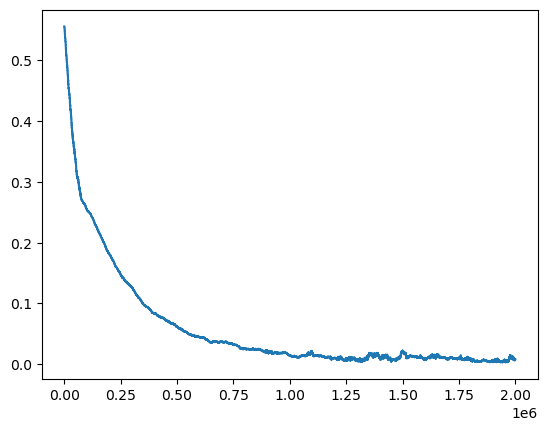

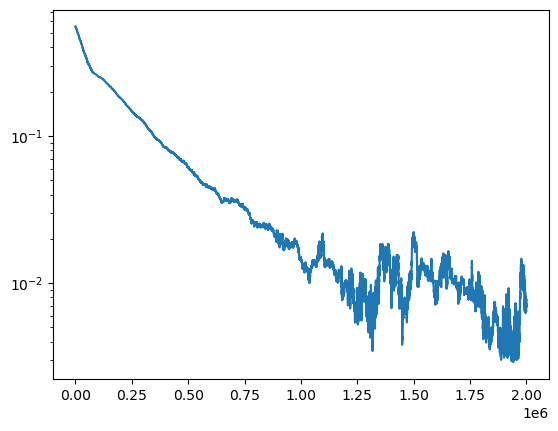

In [3]:
import gymnasium as gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
from solutions.fl_policy_eval_iter_mat2 import policy_eval_iter_mat2
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v1', render_mode="ansi")
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=int)

# Model-based value function computation
V_pi0, residuals = policy_eval_iter_mat2(env,pi0,1e-4,10000)

# Run TD(0)
gamma = 0.9
alpha = 0.001
max_steps = int(2e6)
Vinit = np.zeros((env.observation_space.n))
Vtd, error = TD_Veval(env=env, pi=pi0, max_steps=int(2e6), alpha=alpha, gamma=gamma, Vinit=Vinit, Vtrue=V_pi0)

# Display
print(Vtd)
print(V_pi0)
plt.plot(error)
plt.figure()
plt.semilogy(error);

In general, we will call $\beta$ the *behavior policy*. It is the policy being applied to interact with the environment. Off-policy evaluation algorithms can use a behavior policy that is different than the policy being evaluated. We will call *behavior distribution* the distributions $\rho^\beta(s)$ over states and $\rho^\beta(s,a)$ over state-action pairs, induced by applying $\beta$.

## Delayed updates and experience replay for TD(0)

We have seen that TD(0), at each time step, takes a gradient step in the direction of $T^\pi Q$.

The result of this gradient step is an approximation of $T^\pi Q$.

We saw in class that despite the (bounded) error $\epsilon$ made by an approximation operator $\mathcal{A}$, the sequence $Q_{n+1} = \mathcal{A} T^* Q_n$ still reached a neighborhood of $Q^*$ (without necessarily converging). The same result holds for the sequence $Q_{n+1} = \mathcal{A} T^\pi Q_n$.

One single step of stochastic gradient descent makes for a poor approximator. Given a fixed function $Q_n$, if we repeat a certain number $C$ of such gradient steps, we can hope to obtain a better estimate of $T^\pi Q_n$. So there is an interest in keeping two $Q$ functions in memory. The first is the current estimator, which plays the role of $Q_n$, upon which we apply $T^\pi$, and which we call the *target* function, sometimes noted $Q^-$ (especially in deep Q-learning). The second is the one we actually optimize and which aims at approximating $T^\pi Q^-$; we write it $Q$. Every $C$ gradient steps, as $Q$ is hopefully getting close to $T^\pi Q^-$, we replace $Q^-$ by $Q$ and repeat.

Consequently, this procedure of **delayed updates** trades off advancing in the $Q_{n+1} = \mathcal{A} T^\pi Q_n$ sequence for better approximation properties for $\mathcal{A}$.

This makes more apparent the remark made before that TD(0) actually solves the $Q_{n+1} = T^\pi Q_n$ sequence and thus successively minimizes a sequence of losses:
$$L_n(Q) = \| Q - T^\pi Q_n \|_2.$$
The loss changes everytime we replace $Q_n$ by $Q$.

<div class="alert alert-warning">
    
**Exercise:**  
What's the value of $C$ in vanilla TD(0)?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Vanilla TD(0) replaces $Q^-$ by $Q$ at every step, so $C=1$.
</details>

We have written several times the update of TD(0) with a batch of samples. But in order to be able to perform stochastic gradient steps using more than one sample, one needs to keep samples in memory.

Recall the loss we defined to introduce the stochastic gradient update:
$$L(Q) = \frac{1}{2} \int_{S\times A} \left[ Q(s,a) - \mathbb{E}\left(G^\pi(s,a)\right)\right]^2 \rho(s,a) ds da.$$

Recall also that $d = \frac{1}{N} \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_Q Q(s_i,a_i)$ is an unbiased estimate of $\nabla_Q L(Q)$ only if the $g^\pi(s_i,a_i)$ are drawn **independently** and **identically** according to the distribution of $G^\pi(s,a)$.

This last condition can only be verified if 
1. the $s_i,a_i$ are drawn independently of each other and always according to the same distribution $\rho(s,a)$, and
2. given $s_i,a_i$, the realizations $g^\pi(s_i,a_i)$ are drawn independently of each other and according to the distribution of $G^\pi(s_i,a_i)$.

<div class="alert alert-warning">
    
**Exercise:**  
What do you think? Is condition 1 verified in vanilla TD(0)? What about condition 2?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Let's write $(s_i,a_i,r_i,s'_i)$ the $i$th sample and $\beta$ the behavior policy.
    
Condition 1 is not verified for vanilla TD(0). It is true that if the behavior policy $\beta$ is constant, then on average the state samples $s_i$ are drawn **identically**, according this policy's state distribution $\rho^\beta(s)$ and the action samples are drawn according to $\beta(\cdot | s)$. However, successive samples are not drawn **independently** by definition, since $\mathbb{P}(S_{t+1})$ is actually conditioned by $S_t$ and $A_t\sim\beta(\cdot | S_t)$.

    
Condition 2, on the other hand is easier to verify for TD(0) updates: since the reward $r_i$ and the next state $s'_i$ are only conditioned by $s_i$ and $a_i\sim \beta(\cdot | s_i)$, the $g^\pi(s_i,a_i) = r_i + \gamma Q(s'_i,\pi(s'_i))$ are all drawn identically and independently of each other.
</details>

Despite this, TD(0) with tabular function representation still converges as long as states and actions are tried frequently enough. In some cases of function approximation this is also still true. But we might have found a major issue here in the most general case.

One way to (approximately) recover the conditional independence of sampled states $s_i$ is to store a large number of samples $(s_i,a_i,r_i,s'_i)$ in memory, and draw samples uniformly at random from this memory for the TD(0) updates. This idea was first introduced by Lin in his 1992 **[Self-improving reactive agents based on reinforcement learning, planning and teaching](https://link.springer.com/article/10.1007/BF00992699)** article, under the name of *experience replay* (although his derivation was not exactly the same and was applied to the Q-learning algorithm, which we reserve for another class).

The memory of samples is generally called an **experience replay memory** or **experience replay buffer**, since it allows the learning agent to store past experience in memory and recall it (replay it) as many times as necessary to facilitate learning.

Drawing uniformly randomly from a replay buffer preserves the stationary distribution which generated the samples and breaks the conditional dependency between successive samples in a trajectory.

Combined with the delayed updates introduced earlier, this yields a general, practical algorithm:

<div class="alert alert-success">
    
**TD(0) with delayed updates, experience replay and parametric function approximation:**  
Given a set of samples $\left\{(s_i,a_i,r_i,s'_i)\right\}_{i\in [1,N]}$ all drawn from a fixed behavior distribution, an initial *target* function $Q^-$, and a parametric function approximator $Q_\theta$, the gradient update is:
$$\theta \leftarrow \theta + \alpha \sum_{i=1}^N \left[ r_i + \gamma Q^-(s'_{i},\pi(s'_i)) - Q_\theta(s_i,a_i) \right] \nabla_\theta Q_\theta(s_i,a_i)$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, under the Robbins-Monro conditions, and under repeated substitution of $Q^-$ by $Q_\theta$ every $C$ gradient updates, this procedure reaches values for $\theta$ such that $Q_{\theta}$ is within a neighborhood of $Q^\pi$.
</div>

Recall that for finite state and action spaces, one can take the parameterization $\theta$ to be the vector of values taken by $Q$ in eacg state-action pair. This provides an algorithm with no error due to function approximation (but still possible errors due to gradient descent steps and unsuitable behavior policy).

<div class="alert alert-warning">
    
**Exercise:**  
Write a TD(0) algorithm with experience replay in frozen lake.
</div>

In [ ]:
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line in the cell below to load a correction (then you can execute this code).

In [ ]:
#%load solutions/no_solution_yet.py

## The importance of the behavior distribution

Let us rephrase an aspect seen in class and understand what is really minimized when we perform SGD with a replay buffer.

We have written above that TD(0) on $Q$ functions is an off-policy algorithm since it will estimate $Q^\pi$ whatever the behavior policy is, as long as this policy explores all state-action pairs infinitely often.

This is actually only true if we are working with tabular representations of $Q$ functions.

Let's return to the gradient descent formulation for a minute. We wrote that the loss was:
$$L(Q) = \int_S \int_A \left[ Q(s,a) - \mathbb{E}\left(G^\pi(s,a)\right)\right]^2 \rho(s,a) ds da.$$
    
And we wrote the Monte Carlo estimate of this loss' gradient:
$$d = \frac{1}{N} \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_Q Q(s_i,a_i).$$

This is actually only correct if the samples $(s_i, a_i)$ are drawn according to some fixed $\rho(s,a)$ distribution in $S \times A$. But in practice, the samples are drawn in $S\times A$ according to the behavior distribution $\rho^\beta(s,a)$.

Let us get back to the general formulation of stochastic gradient descent. For this, we will introduce a distribution $\Gamma$ over $S\times A\times \mathbb{R}$ that describes the joint distribution of state-action pairs $(s,a)$ and long term returns $G^\pi(s,a)$ under policy $\pi$. So, given a behavior distribution $\rho^\beta(s,a)$, essentially:
$$\Gamma(s,a,g^\pi) = \rho^\beta(s,a) \mathbb{P}(G^\pi(s,a)=g^\pi|s,a)$$

Then finding $Q^\pi$ amounts to solving the minimization problem $\min_Q L(Q)$ with:
\begin{align*}
L(Q) &= \mathbb{E}_{s,a,g^\pi \sim \Gamma} \left[ \left(Q(s,a) - g^\pi\right) \right],\\
     &= \int_S \int_A \int_\mathbb{R} \left[ Q(s,a) - g^\pi \right]^2 \Gamma(s,a,g^\pi) ds da dg^\pi.
\end{align*}

Then, **if the samples $(s,a,g^\pi)$ are drawn according to $\Gamma(s,a,g^\pi)$**, the Monte Carlo estimate
$$d = \frac{1}{N} \sum_{i=1}^N \left[ Q(s_i,a_i) - g^\pi(s_i,a_i)\right] \nabla_Q Q(s_i,a_i)$$
is actually a correct estimate of $\nabla_Q L(Q)$.

What does it mean that $(s,a,g^\pi)$ are drawn according to $\Gamma(s,a,g^\pi)$? It means state-action pairs are drawn according to $\rho^\beta(s,a)$ and the $g^\pi(s_i,a_i)$ follow the distribution of $G^\pi(s,a)$

Otherwise, this Monte Carlo estimate it is a biased estimator that minimizes another loss function; for example one defined by another behavior distribution $\rho^\beta(s,a)$.

So when we are summing elements drawn from the replay memory, or when we are using single samples drawn from the interaction with the MDP, we are actually minimizing the loss function defined specifically by $\rho^\beta(s,a)$. And in the end, for another behavior distribution, the resulting minimizer $Q$ of the loss might be different from the one obtained by using samples collected with $\rho^\beta$.

So, does that mean TD(0) on $Q$ functions is not really off-policy?

In the case of tabular representations, the fact that the gradients $\nabla_Q Q(s_i,a_i)$ are actually indicator functions of $(s_i, a_i)$ limits the impact of having different distributions on $S\times A$. In this case, the minimizers of $L(Q)$ are actually all the same across behavior distributions, as long as the behavior distribution's support spans fully $S\times A$.

However, this nice property is lost in the general case, in particular in the case of function approximation $Q_\theta$. This has motivated the introduction of the **[Gradient Temporal Difference](https://proceedings.neurips.cc/paper/2008/hash/e0c641195b27425bb056ac56f8953d24-Abstract.html)** family of algorithms. This topic is beyond the scope of this class but the interested reader is encouraged to look at **[H. R. Maei's PhD thesis](https://era.library.ualberta.ca/items/fd55edcb-ce47-4f84-84e2-be281d27b16a)**.

## Monte Carlo evaluation

When evaluating a given policy, we directly *bootstrapped* the estimator of $V^\pi(s_t,a_t)$, by writing $g_t^\pi = r_t + \gamma V_t(s_{t+1})$.

But an immediate way to estimate $V^\pi(s)$ is to take the empirical average of a series if realizations of the $\sum\limits_{t = 0}^\infty \gamma^t R_t$ random variable.

In plain words: simulate $\pi$ from $s$ a certain number of times to obtain trajectories, observe and accumulate the rewards along each trajectory, take the empirical average over all trajectories.

That is precisely what we did in the homework of the class on MDPs to estimate the value of the starting state.

In [ ]:
# %load solutions/fl_mc_eval.py
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np

def mc_eval(env,pi,nb_trials):
    horizon = 200
    gamma = 0.9
    Vepisode = np.zeros(nb_trials)
    for i in range(nb_trials):
        state,_ = env.reset()
        for t in range(horizon):
            next_state, r, done, _, _ = env.step(pi[state])
            Vepisode[i] += gamma**t * r
            state = next_state
            if done:
                break
    return Vepisode

This provided an estimate of $V^\pi(s_0)$. Can we generalize this to learning the value $V^\pi$ in all states?

Let us start with a fully **offline Monte-Carlo** algorithm. The idea is simple: start from $s$, run the policy until termination (or for a long number of steps), repeat for a number of episodes, then update the value of all encountered states. This requires to store in memory full episodes (it also requires that the episodes be finite-length).

But we can immediately do better with an **online Monte-Carlo** method. It is almost the same idea: start from $s$, run the policy until termination (or for a long number of steps) then update the value of all encountered states before restarting an episode.  

Let $(s_0, r_0, s_1, \ldots, s_T)$ be the sequence of transitions of such an episode.  
For the sake of clarity we will slim down our notations: $g^\pi(s_t)$ becomes $g_t$.  
Then, this sequence provides a sample $g_t$ of $G^\pi(s_t)$ for all $s_t$ visited during the simulations. 
<div class="alert alert-success"><b>Monte Carlo return:</b>
$$g_t = \sum_{i>t} \gamma^{i-t} r_i$$
</div>

<div class="alert alert-warning">
    
**Exercise:**  
Write a function `MC_Veval(env, pi, max_steps, max_episodes, alpha, gamma, Vinit=None, Vtrue=None)` that implements an online Monte Carlo estimator. This function runs `max_episodes` rollouts of length at most `max_steps` of `env` controled by `pi`. After each episode, it uses the collected rewards to update the `gamma` discounted value of all encountered states, using a stochastic approximation procedure of constant learning rate `alpha`. It starts from a `Vinit` value function estimate and compares the estimate of $V^\pi$ after each episode to `Vtrue` if provided. It returns the estimate of $V^\pi$, an array indicating the cumulated number of time steps after each episode, and the $L_\infty$ of the difference between the current estimate and `Vtrue`.   
Apply this function to the policy that always moves right in FrozenLake.
</div>

In [ ]:
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line in the cell below to load a correction (then you can execute this code).

In [ ]:
# %load solutions/fl_MC_Veval.py

In [ ]:
import gymnasium as gym
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np
from solutions.fl_policy_eval_iter_mat2 import policy_eval_iter_mat2
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v1', render_mode="ansi")
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=int)

# Model-based value function computation
V_pi0, residuals = policy_eval_iter_mat2(env,pi0,1e-4,10000)

# Online MC estimation
gamma = 0.9
alpha = 0.001
max_steps = 1000
max_episodes = 100000
Vinit = np.zeros((env.observation_space.n))
Vmc,cumulated_steps,error = MC_Veval(env, pi0, max_steps, max_episodes, alpha, gamma, Vinit, V_pi0)

# Display results
print(Vmc)
print(V_pi0)
plt.plot(cumulated_steps,error)
plt.figure()
plt.semilogy(cumulated_steps,error);

So online Monte-Carlo allows us to update $V^\pi$ episode after episode. Some values are better estimated than others depending on how often the corresponding state was visited.

Monte-Carlo estimation has some flaws nonetheless. It still requires to store one full episode in memory before $V$ is updated. Also, one rare value for $r_t$ affects directly all the value of the states encountered before $s_t$. So we can question the robustness of this estimator.

## TD(lambda)

With Monte Carlo (MC) and TD(0), we have two methods with different features:
- TD(0): 1-sample update with bootstrapping
- MC: $\infty$-sample update with no bootstrapping

What's inbetween?
- inbetween: $n$-sample update with bootstrapping

In previous classes, we introduced the state-action *bootstrapped return* random variable $G^\pi_m(s,a,Q)$, for $m\geq 1$:
$$G^\pi_m(s,a,Q) = \sum\limits_{t = 0}^{m-1} \gamma^t R_t + \gamma^m Q(S_m, A_m) \quad \Bigg| \quad \begin{array}{l}S_0 = s, A_0=a\\ A_t \sim \pi(S_t)\textrm{ for }t>0,\\ S_{t+1}\sim p(\cdot|S_t,A_t),\\R_t = r(S_t,A_t,S_{t+1}).\end{array}$$

We could define a similar state bootstrapped return random variable $G^\pi_m(s,a,Q)$, for $m\geq 1$:
$$G^\pi_m(s,V) = \sum\limits_{t = 0}^{m-1} \gamma^t R_t + \gamma^m V(S_m) \quad \Bigg| \quad \begin{array}{l}S_0 = s\\ A_t \sim \pi(S_t),\\ S_{t+1}\sim p(\cdot|S_t,A_t),\\R_t = r(S_t,A_t,S_{t+1}).\end{array}$$

Since one generally uses $n$ to count time steps, we will replace $m$ by $n$ in what follows. 
This $G^\pi_n(s,V)$ random variable is called the **$n$-step starget** or **$n$-step return**. 
As in the previous section, we will discard the implicit $\pi$ and $V$ and slim down our notations to write $G^{(n)}_t = G^\pi_n(s_t,V_t)$.
The $n$-step return $G^{(n)}_t$ from state $s_t$ is the random variable:

$$
\begin{array}{l|l}
G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots & \textrm{MC}\\
G^{(1)}_t = R_t + \gamma V_t(S_{t+1}) & 1\textrm{-step TD = TD(0)}\\
G^{(2)}_t = R_t + \gamma R_{t+1} + \gamma^2 V_t(S_{t+2}) & 2\textrm{-step TD}\\
G^{(n)}_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots + \gamma^n V_t(S_{t+n}) & n\textrm{-step TD}
\end{array}
$$

And we define the **$n$-step TD update** as:
<div class="alert alert-success">
    
**$n$-step TD update:**
$$V(s_t) \leftarrow V(s_t) + \alpha \left[ G^{(n)}_t - V(s_t) \right]$$
</div>

<div class="alert alert-warning">
    
**Exercise:**  
Suppose that the immediate reward $R$ has a constant variance $\sigma^2$ and that for all states $s$ the estimator $V(s)$ of $V^\pi(s)$ has bias $\epsilon$.  
What is the variance of $G_t^{(n)}$?  
What is the bias of $\mathbb{E}\left(G_t^{(n)}(s)\right)$ as an estimator of $V^\pi(s)$?  
Comment on the impact of choosing a certain value for $n$.
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Reminder: $var(X+Y)=var(X)+var(Y)$ and $var(aX)=a^2 var(X)$.  
Consequently:
\begin{align*}
    var(G_t^{(n)}) &= \sum_{i=0}^{n-1} \gamma^{2i} \sigma^2 + \gamma^{2n} var(V_t(S_{t+n}))\\
     &= \frac{1-\gamma^{2n}}{1-\gamma^2}\sigma^2 + \gamma^{2n} var(V_t(S_{t+n}))
\end{align*}
    
The variance grows with $n$, both because $1-\gamma^n$ grows with $n$ and because $S_{t+n}$ has larger variance as $n$ grows.
    
On the bias side:
\begin{align*}
    \mathbb{E}\left(G_t^{(n)}(s)\right) - V^\pi(s) &= \mathbb{E}\left(G_t^{(n)}(s)\right) - \mathbb{E}\left(\sum_{i=0}^\infty \gamma^t R_t\right)\\
    &=\mathbb{E}\left(\sum_{i=0}^{n-1} \gamma^i R_{t+i} + \gamma^n V_t(S_{t+n})\right)  - \mathbb{E}\left(\sum_{i=0}^\infty \gamma^t R_t\right)\\
    &=\gamma^n \left[ \mathbb{E}\left(V_t(S_{t+n})\right) - \mathbb{E}\left(\sum_{i=n}^\infty \gamma^t R_t \right) \right]\\
    &=\gamma^n \left[ \mathbb{E}\left(V_t(S_{t+n})\right) - V_t(S_{t+n}) \right]\\
    &=\gamma^n \epsilon
\end{align*}
    
So the bias decreases with $n$. This makes sense since $V_t$'s importance is weighted by $\gamma^n$.
    
Consequently, choosing a value for $n$ is making a bias-variance tradeoff. Small $n$ means small variance and large bias, large $n$ means large variance and small bias. Thus, choosing an intermediate value has in interest in accelerating the convergence of TD algorithms.
</details>

So MC corresponds to an $\infty$-step TD update.  
    
The $n$-step TD update algorithm converges to the true $V^\pi$ just as TD(0) or MC. It requires to wait for $n$ time steps before performing an update.

Remark: for finite-length  episodes of length $T$, all $n$-step returns for $n>T-t$ are equal to the Monte Carlo return $G_t$.

So $n$-step TD updates bridge a gap between MC and TD(0). But it's not quite satisfying yet because we never really know what value of $n$ is appropriate to speed up convergence for a given problem. An interesting property is that we can mix $n$ and $m$-step returns together. Consider $G^{mix}_t = \frac{1}{3} G^{(2)}_t + \frac{2}{3} G^{(4)}_t$.
Then the update $V(s_t) \leftarrow V(s_t) + \alpha \left[G^{mix}_t - V(s_t)\right]$ still converges to $V^\pi$. More generally, convex sums of $n$-step returns yield update procedures that still converge to $V^\pi$.

Now, take $\lambda\in [0,1]$ and consider the $\lambda$-return $G^\lambda_t$:
<div class="alert alert-success"><b>$\lambda$-return:</b>
$$G^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$
</div>

The $\lambda$-return is the mixing of *all* $n$-step returns, with weights $(1-\lambda) \lambda^{n-1}$. So, an agent performing a $\lambda$-return update looks one step in the future and uses that step to update $V(s)$ with weight $(1-\lambda)$, then looks 2 steps into the future and updates $V(s)$ with a weight $\lambda (1-\lambda)$ and so on. The illustrative figure below is an excerpt from **Reinforcement Learning: an introduction** by Sutton and Barto.

<center><img src="img/TD_lambda_forward.png"></img></center>

To get a better understanding of the $\lambda$-return and to set ideas, let us consider a finite length episode $(s_t, r_t, s_{t+1}, \ldots, s_T)$. Since the episode ends after $T$, we have $\forall k>0, \ G^{(T-t+k)}_t = G_t$. Thus, we can split the $\lambda$-return sum in two:

\begin{align*}
G^\lambda_t & = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \left(1-\lambda\right) \sum\limits_{n=T-t}^{\infty} \lambda^{n-1}G_t^{(n)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \left(1-\lambda\right) \lambda^{T-t-1} \sum\limits_{n=T-t}^{\infty} \lambda^{n-T+t} G_t^{(n)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \left(1-\lambda\right) \lambda^{T-t-1} \sum\limits_{k=0}^{\infty} \lambda^{k} G_t^{(T-t+k)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \lambda^{T-t-1} G_t\\
\end{align*}

So we have $G^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}G_t^{(n)} + \lambda^{T-t-1} G_t$.
- When $\lambda = 0$, it is a $TD(0)$ update (hence the "0" in TD(0)).
- When $\lambda = 1$, it is a MC update.
So we can define the **$\lambda$-return algorithm** that generalizes on TD(0) and MC:
<div class="alert alert-success"><b>$\lambda$-return algorithm:</b>
$$V(s_t) \leftarrow V(s_t) + \alpha \left[G^{\lambda}_t - V(s_t)\right] $$
</div>

That's all very nice and we have replaced the choice of $n$ by the choice of $\lambda$, which seems less sensitive. But, still, we don't know how to compute those $n$-step returns, and the $\lambda$-return, without running $n$-step episodes (and thus infinite episodes for the $\lambda$-return in the general case).

This is where we need to flip the little man in the drawing above to make him look backwards in time. When an agent transitions from $s$ to $s'$ and obtains reward $r$, it can compute the $1$-step return for $s$ and perform the corresponding $1$-step TD update. Then, as it transitions from $s'$ to $s''$ and observes $r'$ it can perform the $1$-step TD update in $s'$, but also the $2$-step TD update in $s$! An so on for future transitions. So, incrementally, as time unrolls, the agent will include the $n$-step updates in the $\lambda$-return of $s$ as they become available. In the limit, when $t\rightarrow\infty$, the $\lambda$-return in every state will be complete and the agent will have completed a $\lambda$-return algorithm. This figure below (excerpt from **Reinforcement Learning: an introduction** by Sutton and Barto) illustrates this *backward-view* on TD updates.

<center><img src="img/TD_lambda_backward.png"></img></center>

This seems to imply that we need to remember the states we went through, which is quite the same as remembering full episodes for MC updates. But since we want to update a state seen $n$ steps ago with a weight $\lambda^n (1-\lambda)$, we just need to remember, for each state, the last time we visited it (and we can forget about the trajectory linking states together). This way, we store $|S|$ values at all time, instead of an increasingly long sequence of transitions. In order to do this, we introduce the notion of **eligibility trace**:
<div class="alert alert-success"><b>Eligibility trace of state $s$:</b>
$$e_t(s) = \left\{\begin{array}{ll}
\gamma \lambda e_{t-1}(s) & \textrm{if }s\neq s_t\\
1 & \textrm{if }s = s_t
\end{array}\right.$$
</div>

Initially, all states have an eligibility trace of zero. The eligibility trace of an unvisited state decays exponentially. So $e_t(s)$ measures how old the last visit of $s$ is.

Note that two alternative definitions of eligibility traces prevail:
<ul>
    <li> "<b>replacing traces</b>": $e_t(s) = 1\textrm{ if }s = s_t$
    <li> "<b>accumulating traces</b>": $e_t(s) = e_{t-1}(s) + 1\textrm{ if }s = s_t$
</ul>
Often (not always), replacing traces are used in practice.<br>
<br>
And finally we can define the TD($\lambda$) algorithm:
<div class="alert alert-success"><b>TD($\lambda$) algorithm:</b><br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1 & \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
Initially, $e(s)=0$.
</div>

Properties and remarks:
- Earlier states are given $e(s)$ *credit* for the TD error $\delta$
- If the environment contains terminal states, then $e$ should be reset to zero whenever a new trajectory begins.
- If $\lambda=0$, $e(s)=0$ except in $s_t$ $\Rightarrow$ standard TD(0)
- For $0<\lambda<1$, $e(s)$ indicates a distance $s \leftrightarrow s_t$ is in the episode.
- If $\lambda=1$, $e(s)=\gamma^\tau$ where $\tau=$ duration since last visit to $s_t$ $\Rightarrow$ MC method<br>
TD(1) implements Monte Carlo estimation on non-episodic problems!<br>
TD(1) learns incrementally for the same result as MC
- **TD($\lambda$) is equivalent to the $\lambda$-return algorithm.**
- The value of $\lambda$ can even be changed during the algorithm without impacting convergence.
- TD($\lambda$) is an on-policy algorithm: samples must be collected following the policy under evaluation.

Note that TD($\lambda$) is already a batch update (it already updates all state values) but not in the sense of SGD batches.

However, in the presentation given above, since the eligibility trace $e(s)$ is defined state by state, the formulation of TD($\lambda$) is limited to discrete state spaces and tabular function representations. The section on function approximation further down will provide an extension of TD($\lambda$) to linear function approximation.

The extension of TD($\lambda$) to the off-policy setting has been undertaken in the more general work about **[Gradient Temporal Differences](https://era.library.ualberta.ca/items/fd55edcb-ce47-4f84-84e2-be281d27b16a)** quoted earlier.

<div class="alert alert-warning"><b>Exercise:</b><br>
Implement a TD($\lambda$) algorithm to estimate $V^\pi$ fo the policy that always goes right. As before, take a constant $\alpha=0.001$, $\gamma=0.9$ and $\lambda=0.5$. Run the algorithm for 2000000 steps.
</div>

In [ ]:
# %load solutions/RL3_exercise4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

In [ ]:
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line in the cell below to load a correction (then you can execute this code).

In [ ]:
# %load solutions/fl_TDlambda_Veval.py

In [ ]:
import gymnasium as gym
import gymnasium.envs.toy_text.frozen_lake as fl
import numpy as np
from solutions.fl_policy_eval_iter_mat2 import policy_eval_iter_mat2
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v1', render_mode="ansi")
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=int)

# Model-based value function computation
V_pi0, residuals = policy_eval_iter_mat2(env,pi0,1e-4,10000)

# TD(lambda) estimation
gamma = 0.9
lambd = 0.5
alpha = 0.001
max_steps = 2000000
Vinit = np.zeros((env.observation_space.n))
Vtdl, error = TDlambda_Veval(env, pi0, max_steps, alpha, gamma, lambd, Vinit, V_pi0)

# Display results
print(Vtdl)
print(V_pi0)
plt.plot(error)
plt.figure()
plt.semilogy(error);

## Value function approximation

Often, $S$ is not finite (or is just too large to be enumerated). Consequently, $\mathbb{R}^S$ has infinite (or just too large) dimension. Thus, tabular representations of $V$ are not possible and one needs to turn to function representations $V_\theta$ or $Q_\theta$ with parameters $\theta$. In this section, we provide a very short discussion on approximation methods for $V$ and $Q$.

The FrozenLake example is a toy problem with very few states (moreover discrete). It does not lend itself to a convincing demonstration of value function approximation. We shall remain at the theoretical level for the following considerations and reserve practice for later.

**Linear value function approximation**

Suppose we write $V$ as a linear model:
$$V(s) = \theta^T \varphi(s) = \sum_{i=1}^K \theta_i \varphi_i(s)$$

We wish to approximate $V(s)$ as a linear combination of features $\varphi(s)=\left(\varphi_i(s)\right)_{i\in[1,K]}$. This way, $V$ lives in the $K$-dimensional function space $span(\varphi)$. We have plenty of families of functions that we can rely on and the user's expertise plays a big role in choosing a proper **functional basis**. Generally speaking, we would expect the following properties from a good basis:
- the target $V^\pi$ can be closely approximated by its projection on $\varphi$
- given an initial $V_0 \in span(\varphi)$ and the recurrence relation $V_{n+1} = \Pi_\varphi (T^\pi V_n)$ (where $\Pi_\varphi$ is the projection operator on $span(\varphi)$), $V_n$ should be a "close enough" approximation of $T^\pi V_n$. This property is illustrated by the figure below with $Q$ instead of $V$ - excerpt from **[Least-Squares Policy Iteration](https://www.jmlr.org/papers/v4/lagoudakis03a.html)** by M. G. Lagoudakis and R. Parr (2003).
- $\varphi$ should form a basis (that is $\varphi_i \bot \varphi_j$)

<img src="img/projection.png" style="width: 600px;"></img>

If $\sum_{i=1}^K \varphi_i(s) = 1$, then $V_\theta$ is called an *averager*. Averagers are known to be well-behaved for iterative function approximation. Otherwise, other non-averager families of functions are commonly used:

- $\cos$, $\sin$ over state variables (mimics the Fourier transform, extends to wavelet bases)
- polynomials of the state variables (mimics the Taylor expansion)
- radial basis functions of the state variables (performs local approximation, extends to kernel smoothing).
- among averagers, piecewise constant local functions $\varphi_i(s) \in \{0;1\}$ group *neighborhoods* in the state space together (note the similarity with tree-based regressors).

A very straightforward way of building feature sets is to define features depending on a single state variable and then using the tensor product in order to obtain all possible combinations of single-variable features. More formally and more generally, suppose $S \subset S_1\times \ldots \times S_k$ and suppose $\varphi^{(i)}$ defines $d_i$ features over $S_k$; then the tensor product $\varphi^{(1)} \otimes \ldots \otimes \varphi^{(k)}$ yields $d=d_1\ldots d_k$ feature functions on $S$. But there is a catch, the number of these resulting features grows exponentially with $k$ and so does the dimension of the value function's search space $span(\varphi)$: that is the **curse of dimensionality** that makes searching for a value function exponentially more difficult as the state space dimension grows.

Additionnaly, there is **no guarantee** that, for a given $V_n \in span(\varphi)$, $T^\pi V_n$ actually lives in $span(\varphi)$.

But on the bright side, given an initial state $s_0$, the actual reachable space $S'$ given $\pi$ might be much smaller than $S$. So, in practice, we just need to obtain a good approximation of $V$ on the subspace $S'$.

Anyway, to conclude this short paragraph on feature engineering:
- good feature engineering in RL is even more crucial than in supervised learning.
- it can be very problem-dependent.
- good function approximators (generally non-parametric to avoid the fixed $span(\varphi)$) are of crucial importance.

Linear function approximation has played a major role in the RL literature, in particular for temporal differences methods. The **[Policy Evaluation with Temporal Differences](https://www.jmlr.org/papers/v15/dann14a.html)** survey by C. Dann et al. (2014) provides a great overview of this literature.

**The tabular case is just a specific case of linear approximation**

<div class="alert alert-warning">

**Exercise:**  
If the sentence above is true, what is the set of basis functions corresponding to a tabular representation of $V$?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

In the discrete state space case, consider the averager defined as:
$$\varphi_i(s) = \left\{\begin{array}{ll}1 & \textrm{if }s=s_i\\ 0 & \textrm{otherwise}\end{array}\right.$$
Feature function $\varphi_i$ is the indicator function of state $s_i$. Therefore, we have $|S|$ feature functions. So when we write $V(s) = \sum_{i=1}^{|S|} \theta_i \varphi_i(s)$, we actually have $V(s_i) = \theta_i$. Therefore the tabular representation of $V$ is equivalent to a linear model with the $\varphi_i$ feature functions.
</details>

Based on the previous exercise, let us rewrite TD($\lambda$) as a linear model update (we take the accumulating traces version; the replacing traces case is equivalent). We had previously:<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1 + \gamma \lambda e(s)& \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
Initially, $e(s)=0$.

The temporal difference can be rewritten $\delta = r_t+\gamma\theta^T \varphi(s_t') - \theta^T \varphi(s_t)$.

The eligibility trace update can be rewritten $e \leftarrow \varphi(s) + \gamma \lambda e$.

Similarly the value update can be rewritten $\theta \leftarrow \theta + \alpha e \delta$.

Remark:  
Recall the discussion on the importance of the behavior distribution? We concluded that tabular representations were a specific case where TD(0) is truly off-policy because the influence of a sample was limited to the value of $Q$ in the corresponding $(s,a)$ pair. This discussion can be generalized for averagers (although it remains an approximation): such local models are well-behaved to suffer less from the shift in behavior distributions.

**TD($\lambda$) as a linear approximation update**

We generalize the previous result to the general linear model case:
<div class="alert alert-success"><b>TD($\lambda$) with linear function approximation:</b><br>
With $V(s) = \sum_{i=1}^K \theta_i \varphi_i(s)$, $e \in \mathbb{R}^K$.<br>
Initially, $e=0$.<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma\theta^T \varphi(s_t') - \theta^T \varphi(s_t)$.
<li> Update eligibility traces for all states $e \leftarrow \varphi(s) + \gamma \lambda e$
<li> Update value function $\theta \leftarrow \theta + \alpha e \delta$
</ol>
</div>

Note that we have provided the results above without proof. We will admit them and refer the reader to RL textbooks for a rigorous justification.

Further reading on TD($\lambda$) with linear function approximation: 
**[True Online TD($\lambda$)](http://proceedings.mlr.press/v32/seijen14.html)** by H. Van Seijen and R. Sutton (2014).  
An unpublished negative result that somehow follows from this article is also that in the general case it is not possible to have a TD($\lambda$) algorithm performing on non-linear function approximation and being equivalent to the $\lambda$-return algorithm.

**Non-parametric models**

Non-parametric models generally refer to function approximators that do not rely on an a-priori fixed finite-dimensional search space and allows the representation space to evolve as needed. Among those non-parametrics models, one can count:
- linear approximations that incrementally enrich the functional basis (e.g. **[this article](https://dl.acm.org/doi/abs/10.1145/1390156.1390251)**).
- general supervised learning methods: SVMs, k-nearest neighbours (kernel smoothing methods), Gaussian Processes, tree-based methods, neural networks, etc.
  In this second category, it is generally useful to distinguish between
  - methods that explicitly minimize the L2 loss defined earlier via SGD (e.g. neural networks),
  - methods that minimize some other loss (e.g. random forests) and provide alternate (better or worse) guarantees.

One quickly realizes that the frontier between parametric and non-parametric models is blur. In the general case of a $s \mapsto V(s)$ function approximator, the general idea is to feed this approximator with samples of the form $(s, r+\gamma V(s'))$. But beware: most of the nice results are generally lost when one leaves the realm of linear function approximation. More precisely, when one combines **function approximation**, **off-policy learning** and **bootstrapping** in a temporal difference method, all results are generally lost. This has been studied as the **[Deadly triad of Reinforcement Learning](https://arxiv.org/abs/1812.02648v1)** (H. Van Hasselt et al., 2018).

## Generalized Policy Iteration and Actor-Critic architectures

Remember how we went from Policy Iteration (figure below) to Asynchronous Policy Iteration?
<center><img src="img/policyiteration.png"></img></center>

Now recall the principle of Asynchronous Policy Iteration. If we consider the two elementary operations:
- Bellman backup on $Q$: $Q(s,a) \leftarrow r(s,a) + \gamma \sum\limits_{s'} p(s'|s,a) Q(s',\pi(s'))$
- Bellman backup on $\pi$: $\pi(s) \leftarrow \arg\max_{a} Q(s,a)$

Then, as long as every state and every action is visited infinitely often for Bellman backups on $Q$ or $\pi$, the sequences of $Q_n$ and $\pi_n$ converge to $Q^*$ and $\pi^*$.

Value Iteration: in each state, one update of $Q$ and one improvement of $\pi$.<br>
Policy Iteration: update $Q$ in all states until convergence, then update $\pi$ in all states.

**Generalized Policy Iteration** is the case where one has two interacting processes: policy evaluation and policy improvement, directly from samples (not from the model anymore). If these processes converge to their respective targets, then Generalized Policy Iteration converges to $Q^*$ and $\pi^*$. Model-free policy evaluation can take many forms: indirect RL, Monte Carlo evaluations, TD methods...

This leads to the definition of the general **actor-critic architectures** (excerpt from [**Algorithms for Reinforcement Learning**](https://sites.ualberta.ca/~szepesva/rlbook.html) by C. Szepesvari):

<img src="img/actor-critic.png"  style="width: 500px;"></img>

In such architectures, an *actor* chooses an action based on the current state and the information provided by the *critic*, while the *critic* constantly aims at learning relevant things in order to help the *actor* decide (value functions for example, or an approximate model).

Almost all Reinforcement Learning algorithms fall into an actor-critic architecture.

## SARSA

<div class="alert alert-warning">

**Exercise:**  
Suppose we modify TD(0) on $Q$-functions so that, instead of picking a random action at each time step, we pick the greedy action with respect to $Q$. What is the risk in doing this?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

A deterministic, greedy policy will not try all actions in all states infinitely often. So we can't guarantee convergence, neither of $Q$ to any policy's $Q^\pi$ (because if some states are not visited no updates will take place for them), nor of the $Q$-greedy policy to $\pi^*$. The conditions for the convergence of Generalized Policy Iteration are just not met.
</details>

To solve this issue we introduce the notion of **Greedy in the limit of infinite exploration** (GLIE) actor:  

<div class="alert alert-success"><b>Greedy in the limit of infinite exploration</b> (GLIE) actor:<br>
A GLIE actor guarantees that:<br>
- All state-action pairs $(s,a)$ are visited infinitely often for updates of $Q$, as $t\rightarrow\infty$:
$$\lim_{t\rightarrow\infty} count_t(s,a) = \infty$$
- As $t\rightarrow\infty$ the actor becomes $Q$-greedy, that is:
$$\lim_{t\rightarrow\infty} \pi_t(a|s) = \mathbb{1}\left(a \in \arg\max_{\hat{a}} Q(s,\hat{a})\right)$$
</div>

An example of GLIE actor is the so-called $\epsilon$-greedy exploration strategy (that we introduced with Q Learning) that uniformly picks a non-greedy action with probability $\epsilon$:
$$\pi_t(a|s) = \left\{\begin{array}{ll}1-\epsilon_t & \textrm{if }a=\arg\max_{\hat{a}} Q(s,\hat{a})\\
\frac{\epsilon_t}{|A|-1} & \textrm{otherwise} \end{array}\right.$$
With a parameter $\epsilon_t>0$ that goes to zero as $t$ tends to $\infty$, one obtains a GLIE actor.

GLIE actors (or policies) enforce the limits of the **exploration vs. exploitation tradeoff**. As long as actors respect the GLIE properties, actor-critic architectures fall within the convergence properties of Generalized Policy Iteration.

With this last definition, we have all the ingredients to define algorithms that evolve to an optimal behaviour.

**A remark**

You might have noticed that the totally random policy we applied in the TD(0) update was a very naive choice. Even if all states are reachable from anywhere in the state space (ergodicity property), they might not all be visited with the same frequency and therefore the convergence to $Q^\pi$ might be delayed because of this uniform exploration strategy.  

The same remark applies to $\epsilon$-greedy exploration strategies that often start with $\epsilon=1$ and let it slowly decrease towards zero. These strategies don't account for the actual *visitation frequencies* of state-action pairs. In some states it might be good to keep a strong exploration probability because they actually have been seldom visited, while in other states, a faster decrease is desirable. This links also to the question of *value propagation* that was underpinned by the asynchronous value iteration remarks in section 6.  

The point here is to notice that $\epsilon$-greedy is a simple, very naive exploration strategy that fits within the GLIE requirements but that much better exploration policies are possible by taking the current state into account (contextual exploration) or by using the values of the temporal difference (prioritized experience replay) and the $Q$ estimate (Boltzmann policies, $E^3$ or $R_{max}$ strategies) for instance.

**SARSA**

The key idea behind the SARSA algorithm is to build a critic that constantly tries to evaluate the value $Q$ of the actor's policy $\pi$, and an actor that tends to be greedy with respect to this critic. The algorithm is written:

<div class="alert alert-success">

**SARSA**  
In $s$, choose (*actor*) $a$ using $Q$, then repeat:
<ol>
<li> Observe $r$, $s'$
<li> Choose $a'$ (<i>GLIE actor</i>) using $Q$
<li> Temporal difference: $\delta=r+\gamma Q(s',a') - Q(s,a)$
<li> Update $Q$: $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$
<li> $s\leftarrow s'$, $a\leftarrow a'$
</ol>
SARSA converges if the actor is GLIE and if $\alpha$ respects the Robbins-Monro conditions.
</div>

It is important to note that SARSA is an **on-policy** critic: it constantly evaluates the current $\pi$... that constantly shifts towards $\pi^*$ by being $Q$-greedy.

The name SARSA comes from the usage of an augmented sample $(s,a,r,s',a')$.<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement an $\epsilon$-greedy SARSA on the FrozenLake problem.<br>
For the decrease of $\epsilon$ we can opt for a division by 2 every million steps.<br>
Keep track of the state-action visitation count, as in the Q-learning example.<br>
You can compare with $Q^*$ and $\pi^*$ obtained during the model-based class.<br>
The utility functions below are here to make the task easier.
</div>

In [ ]:
# Model-based policy optimization and a few utility functions

def value_iteration(V,epsilon,max_iter):
    W = np.copy(V)
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for s in range(env.observation_space.n):
            Q = np.zeros((env.action_space.n))
            for a in range(env.action_space.n):
                outcomes = env.unwrapped.P[s][a]
                for o in outcomes:
                    p  = o[0]
                    s2 = o[1]
                    r  = o[2]
                    Q[a] += p*(r+gamma*V[s2])
            W[s] = np.max(Q)
            #print(W[s])
        residuals[i] = np.max(np.abs(W-V))
        #print("abs", np.abs(W-V))
        np.copyto(V,W)
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

def Q_from_V(V):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[s][a]
            for o in outcomes:
                p  = o[0]
                s2 = o[1]
                r  = o[2]
                Q[s,a] += p*(r+gamma*V[s2])
    return Q

def greedyQpolicy(Q):
    pi = np.zeros((env.observation_space.n),dtype=np.int)
    for s in range(env.observation_space.n):
        pi[s] = np.argmax(Q[s,:])
    return pi

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def to_row_col(s):
    col = s%env.unwrapped.ncol
    row = int((s-col)/env.unwrapped.ncol)
    return row,col

def print_policy(pi):
    for row in range(env.unwrapped.nrow):
        for col in range(env.unwrapped.ncol):
            print(actions[pi[to_s(row,col)]], end='')
        print()
    return

Vinit = np.zeros((env.observation_space.n))
Vstar,residuals = value_iteration(Vinit,1e-4,1000)
Qstar = Q_from_V(Vstar)
print(actions)
print(Vstar)
print(Qstar)
pi_star = greedyQpolicy(Qstar)
print_policy(pi_star)
env.render();

In [ ]:
# %load solutions/RL4_exercise4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

In [ ]:
count_map = np.zeros((env.unwrapped.nrow, env.unwrapped.ncol, env.action_space.n))
for a in range(env.action_space.n):
    for x in range(env.observation_space.n):
        row,col = to_row_col(x)
        count_map[row, col, a] = count[x,a]

fig, axs = plt.subplots(ncols=4)
for a in range(env.action_space.n):
    name = "a = " + actions[a]
    axs[a].set_title(name)
    axs[a].imshow(np.log(count_map[:,:,a]+1), interpolation='nearest')
    #print("a=", a, ":", sep='')
    #print(count_map[:,:,a])
plt.show()
env.render()

The same remark as for TD(0) holds: with a better exploration strategy, the convergence to Qstar could be much more efficient. We can see that some states have been visited (and updated) way more often than others.

<div class="alert alert-warning"><b>Exercices (open questions, no solutions provided):</b><br>
<ul>
<li><b>Context-dependent exploration</b><br>
Can you implement an $(s,a)$-dependent $\epsilon$-greedy exploration strategy (by using the `count` table introduced earlier for instance)?
<li><b>Heuristic initialization on $Q$</b><br>
For Q-learning, can you think of an initialization of $Q$ that would be better than plain zeros (for example by exploiting the maximum 1-step reward $r_{max}$)? One that, for instance, would drive the exploration towards unvisited states?
<li><b>Reward shaping</b><br>
Did you notice that falling into a hole brings no penalty? If we introduced a $-1$ reward for falling into a hole, would it change the optimal policy?
<li><b>SARSA($\lambda$)</b><br>
SARSA is an on-policy method and we've seen that so is TD($\lambda$) so it seems rather straightforward to implement a SARSA($\lambda$) algorithm that, hopefully, will have better convergence properties than plain SARSA.
<li><b>$Q(\lambda)$</b><br>
This time it is not as straightfoward to derive a $Q(\lambda)$ algorithm from TD($\lambda$), precisely because TD($\lambda$) evaluates the policy being applied and not another one. Can you imagine a way to still perform $Q(\lambda)$ updates? An answer is found in Watkins's thesis that introduces Q-learning in 1989. For a more recent approach and other references, see Sutton et al, <b>A new Q($\lambda$) with interim forward view and Monte Carlo equivalence</b>, 2014)
<li><b>SARSA and $Q$-learning with linear value function approximation</b><br>
Can you implement an approximate version of SARSA and $Q$-learning with linear Q-function approximation $Q(s,a)=\theta^T\varphi(s,a)$?
</ul>
</div>

## Fitted Q-Iteration

TODO series of exercises to implement FQI.